In [18]:
!pip install pandas numpy matplotlib seaborn scikit-learn nltk wordcloud gensim spacy plotly -q
!python -m spacy download en_core_web_sm -q

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [19]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from gensim import corpora, models
import spacy
from collections import Counter
import plotly.express as px

In [20]:
df = pd.read_csv(r"C:\Users\saket\Downloads\archive\Amazon-reviews-limpo.csv", nrows=20000)
df = df[["ProfileName", "Score", "Summary", "Text"]].dropna()
df["full_review"] = df["Summary"].astype(str) + " " + df["Text"].astype(str)
def label_sentiment(score):
    if score >= 4:
        return "positive"
    elif score == 3:
        return "neutral"
    else:
        return "negative"
df["sentiment"] = df["Score"].apply(label_sentiment)
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    words = []
    for w in text.split():
        if w not in stop_words and len(w) > 2:
            words.append(lemmatizer.lemmatize(w))
    return " ".join(words)
df["clean_text"] = df["full_review"].apply(clean_text)
df.head()

,ProfileName,Score,Summary,Text,full_review,sentiment,clean_text
0,delmartian,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,Good Quality Dog Food I have bought several of...,positive,good quality dog food bought several vitality ...
1,dll pa,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised Product arrived labeled as J...,negative,advertised product arrived labeled jumbo salte...
2,"Natalia Corres ""Natalia Corres""",4,"""Delight"" says it all",This is a confection that has been around a fe...,"""Delight"" says it all This is a confection tha...",positive,delight say confection around century light pi...
3,Karl,2,Cough Medicine,If you are looking for the secret ingredient i...,Cough Medicine If you are looking for the secr...,negative,cough medicine looking secret ingredient robit...
4,"Michael D. Bigham ""M. Wassir""",5,Great taffy,Great taffy at a great price. There was a wid...,Great taffy Great taffy at a great price. The...,positive,great taffy great taffy great price wide assor...


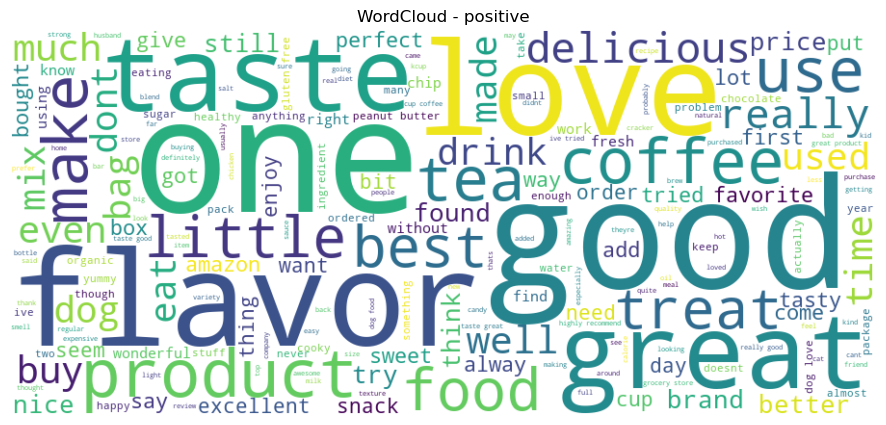

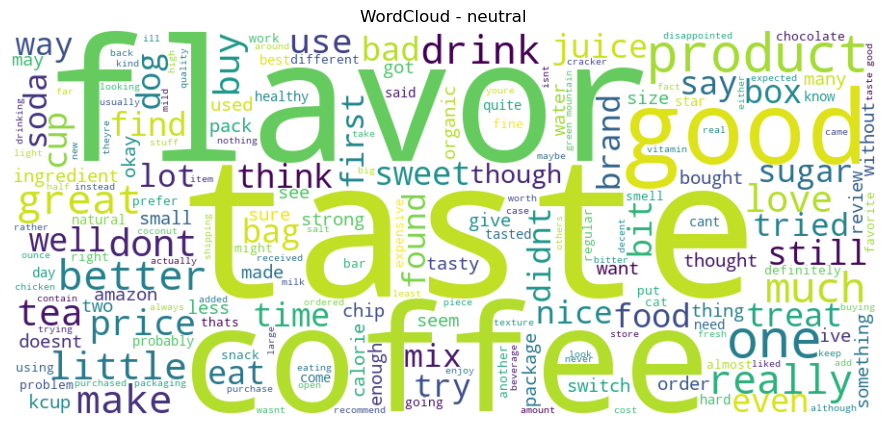

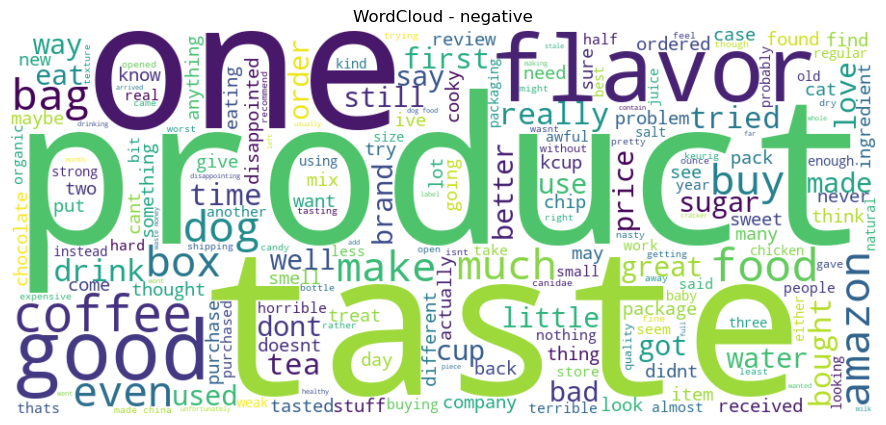

In [21]:
def show_wordcloud(sentiment):
    text = " ".join(df[df["sentiment"] == sentiment]["clean_text"])
    wc = WordCloud(width=900, height=400, background_color="white").generate(text)
    plt.figure(figsize=(12,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud - {sentiment}")
    plt.show()
for s in ["positive", "neutral", "negative"]:
    show_wordcloud(s)

In [22]:
vectorizer = CountVectorizer(ngram_range=(2,2), max_features=5000)
X_bigram = vectorizer.fit_transform(df["clean_text"])
sum_words = X_bigram.sum(axis=0)
bigrams_freq = []
for word, idx in vectorizer.vocabulary_.items():
    bigrams_freq.append((word, sum_words[0, idx]))
bigrams_freq = sorted(bigrams_freq, key=lambda x: x[1], reverse=True)[:15]
for b in bigrams_freq:
    print(b)

('taste like', np.int64(989))
('peanut butter', np.int64(767))
('gluten free', np.int64(669))
('grocery store', np.int64(602))
('dog food', np.int64(588))
('dog love', np.int64(568))
('cup coffee', np.int64(567))
('great product', np.int64(547))
('taste great', np.int64(544))
('highly recommend', np.int64(530))
('taste good', np.int64(510))
('ive tried', np.int64(458))
('much better', np.int64(443))
('hot chocolate', np.int64(411))
('really good', np.int64(396))


In [23]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df["clean_text"])
y = df["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
nb = MultinomialNB()
nb.fit(X_train, y_train)
pred_nb = nb.predict(X_test)
svm = LinearSVC()
svm.fit(X_train, y_train)
pred_svm = svm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred_lr))
print(classification_report(y_test, pred_lr))
print("Accuracy:", accuracy_score(y_test, pred_nb))
print(classification_report(y_test, pred_nb))
print("Accuracy:", accuracy_score(y_test, pred_svm))
print(classification_report(y_test, pred_svm))

Accuracy: 0.863
              precision    recall  f1-score   support

    negative       0.81      0.61      0.70       589
     neutral       0.64      0.17      0.27       330
    positive       0.88      0.99      0.93      3081

    accuracy                           0.86      4000
   macro avg       0.78      0.59      0.63      4000
weighted avg       0.85      0.86      0.84      4000

Accuracy: 0.80175
              precision    recall  f1-score   support

    negative       0.93      0.23      0.36       589
     neutral       0.38      0.01      0.02       330
    positive       0.80      1.00      0.89      3081

    accuracy                           0.80      4000
   macro avg       0.70      0.41      0.42      4000
weighted avg       0.78      0.80      0.74      4000

Accuracy: 0.86125
              precision    recall  f1-score   support

    negative       0.75      0.67      0.71       589
     neutral       0.47      0.21      0.29       330
    positive       0.90

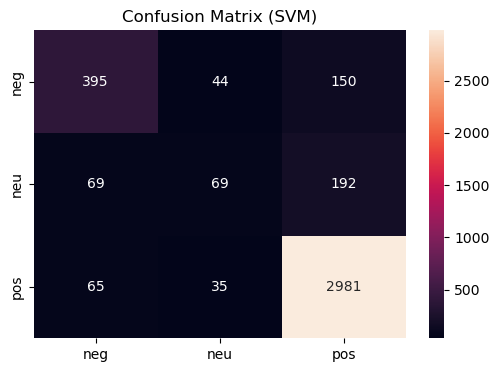

In [24]:
cm = confusion_matrix(y_test, pred_svm, labels=["negative","neutral","positive"])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["neg","neu","pos"],
            yticklabels=["neg","neu","pos"])
plt.title("Confusion Matrix (SVM)")
plt.show()

Topic 1: 0.016*"good" + 0.015*"like" + 0.015*"great" + 0.014*"taste" + 0.010*"love" + 0.009*"product" + 0.009*"flavor" + 0.009*"one" + 0.007*"price" + 0.007*"really"
Topic 2: 0.023*"dog" + 0.017*"food" + 0.015*"treat" + 0.011*"product" + 0.010*"love" + 0.008*"one" + 0.008*"like" + 0.006*"get" + 0.006*"great" + 0.005*"would"
Topic 3: 0.068*"coffee" + 0.024*"cup" + 0.013*"flavor" + 0.013*"like" + 0.012*"good" + 0.011*"great" + 0.011*"blend" + 0.011*"taste" + 0.011*"one" + 0.009*"strong"
Topic 4: 0.052*"tea" + 0.021*"drink" + 0.020*"taste" + 0.017*"flavor" + 0.016*"sugar" + 0.015*"like" + 0.014*"juice" + 0.010*"sweet" + 0.010*"soda" + 0.008*"good"
Topic 5: 0.017*"mix" + 0.013*"use" + 0.012*"oil" + 0.012*"make" + 0.009*"great" + 0.009*"add" + 0.009*"product" + 0.008*"water" + 0.008*"milk" + 0.008*"sauce"


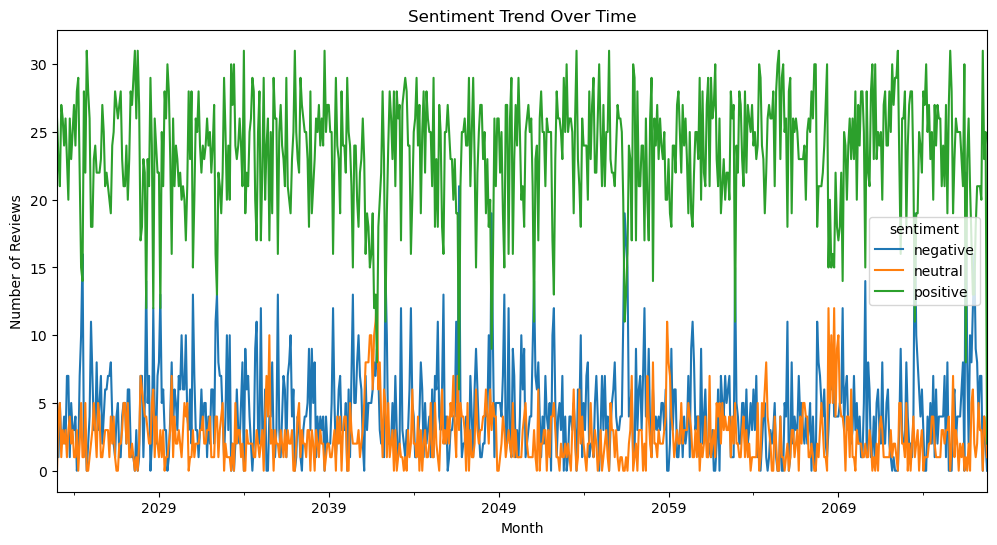

In [25]:
texts = [text.split() for text in df["clean_text"]]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)
for i, topic in lda.print_topics():
    print(f"Topic {i+1}: {topic}")
df["timestamp"] = pd.date_range(start="2023-01-01", periods=len(df), freq="D")
trend = df.groupby([df["timestamp"].dt.to_period("M"), "sentiment"]).size().unstack().fillna(0)
trend.plot(figsize=(12,6))
plt.title("Sentiment Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.show()

In [26]:
nlp = spacy.load("en_core_web_sm")
def extract_entities(text):
    doc = nlp(str(text))
    return [(ent.text, ent.label_) for ent in doc.ents]
print(extract_entities(df["full_review"].iloc[0]))
pos_words = " ".join(df[df["sentiment"]=="positive"]["clean_text"]).split()
neg_words = " ".join(df[df["sentiment"]=="negative"]["clean_text"]).split()
print("\nTop 10 Positive Words:", Counter(pos_words).most_common(10))
print("Top 10 Negative Words:", Counter(neg_words).most_common(10))

[('Vitality', 'ORG'), ('My Labrador', 'PERSON')]

Top 10 Positive Words: [('great', 7553), ('good', 7137), ('like', 6903), ('coffee', 6242), ('love', 5843), ('taste', 5560), ('flavor', 5102), ('one', 4908), ('product', 4704), ('tea', 4023)]
Top 10 Negative Words: [('like', 1693), ('taste', 1526), ('product', 1440), ('one', 1033), ('would', 974), ('coffee', 964), ('flavor', 960), ('good', 875), ('food', 785), ('dog', 728)]


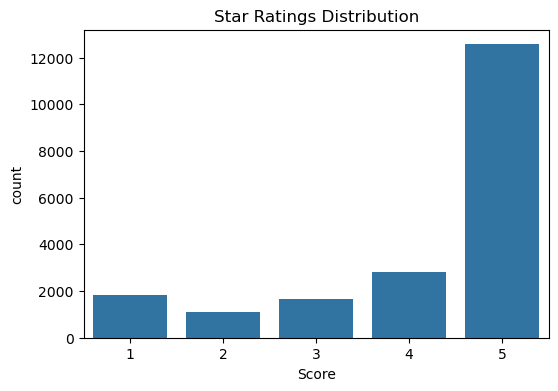

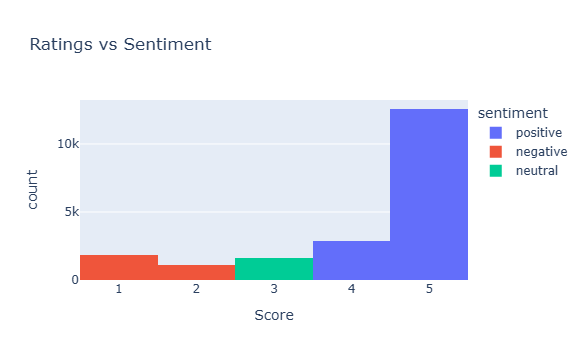

In [27]:
plt.figure(figsize=(6,4))
sns.countplot(x="Score", data=df)
plt.title("Star Ratings Distribution")
plt.show()
fig = px.histogram(df, x="Score", color="sentiment", title="Ratings vs Sentiment")
fig.show()